# Reference


[tf.multiply vs tf.matmul](https://blog.csdn.net/mumu_1233/article/details/78887068)

# Check GPU
```
watch nvidia-smi
```

# Import Library

In [ ]:
import tensorflow as tf
import numpy as np
import pathlib
import pickle
import matplotlib.pyplot as plt
import time
from keras.utils.vis_utils import plot_model

# Set File Path

In [ ]:
pre_path = "/content/drive/MyDrive/Special_Topic/Dataset/MSCOCO_2017/"
glove_path = pre_path + 'GloVe.6B/glove.6B.300d.txt'


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Configuration

In [ ]:
dimension = 1024
caption_max_size = 30
embedding_size = 300
region_num = 30
batch_size = 32
# img_width_times_height = 14 * 14
voc_size = 10193
region_num = 1
regions_set_num = 10

In [ ]:
file_num = 0

# Model

In [ ]:
class Show_Control_and_Tell(tf.keras.Model):
  """
    inputs[0] -> embedding_text (batch_size, caption_max_size, embedding_size) 
    inputs[1] -> mean_pooled_image_feature (batch_size, dimension) 
    inputs[2] -> regions_set (batch_size, regions_set_num, region_num, dimension)
    inputs[2] -> r_t (batch_size, caption_max_size, region_num, dimension)

    outputs[0] -> y_t (batch_size, caption_max_size, dimension)
    outputs[1] -> g_t (batch_size, caption_max_size)
  """
  def __init__(self, input_shape = [(batch_size, region_num, dimension), (batch_size, caption_max_size, embedding_size), (batch_size, caption_max_size)], name = 'Show_Control_and_Tell', **kwargs):
      super(Show_Control_and_Tell, self).__init__(name = name, **kwargs)

  def summary(self, input_shape = [(caption_max_size, embedding_size) ,(dimension) ,  (caption_max_size, region_num, dimension) ]):
      input_layer = [tf.keras.layers.Input(input_shape[i], batch_size = batch_size) for i in range(len(input_shape))]
      # print('input_layer', input_layer)
      self.build([i.shape for i in input_layer])
      out = self.call(input_layer)
      model = tf.keras.Model(inputs=input_layer, outputs=out)
      return model.summary()
  def plot_model(self, input_shape = [(caption_max_size, embedding_size) ,(dimension) ,  (caption_max_size, region_num, dimension) ]):
    input_layer = [tf.keras.layers.Input(input_shape[i], batch_size = batch_size) for i in range(len(input_shape))]
    # print('input_layer', input_layer)
    self.build([i.shape for i in input_layer])
    out = self.call(input_layer)
    model = tf.keras.Model(inputs=input_layer, outputs=out) 
    plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

  def build(self, input_shape):
    # print(input_shape)
    self.batch_size = input_shape[0][0]
    self.dimension = input_shape[1][1]
    self.caption_max_size = input_shape[0][1]
    self.embedding_size = input_shape[0][2]
    self.regions_set_num = input_shape[2][1]
    self.regions_num = input_shape[2][2]

    self.attention_lstm_cell = tf.keras.layers.LSTMCell(
      self.dimension, 
      dropout=0.3,
      recurrent_dropout=0.3,
      name = 'attention_lstm'
    )
    self.language_lstm_cell = tf.keras.layers.LSTMCell(
      self.dimension,
      dropout=0.3,
      recurrent_dropout=0.3,
      name = 'langiage_lstm_cell'
    )

    # set weights
    # Chunk-shifting gate: Equation (2)
    self.W_ig_2 = tf.keras.layers.Dense(units = (self.dimension), name = 'W_ig_2')
    self.W_hg_2 = tf.keras.layers.Dense(units = (self.dimension), name = 'W_hg_2')
     
    # Chunk-shifting gate: Equation (4)
    self.w_h_T_4 = tf.keras.layers.Dense(units = (1), name = 'w_h_T_4')
    self.W_sg_4 = tf.keras.layers.Dense(units = (self.dimension), name = 'W_sg_4')
    self.W_g_4 = tf.keras.layers.Dense(units = (self.dimension), name = 'W_g_4')
    
    # Chunk-shifting gate: Equation (5)
    self.w_h_T_5 = tf.keras.layers.Dense(units = (1), name = 'W_h_t_5')
    self.W_sr_5 = tf.keras.layers.Dense(units = (self.regions_num), name = 'W_sr_5')
    self.W_g_5 = tf.keras.layers.Dense(units = (self.dimension), name = 'W_g_5')
    
    # Adaptive attention with visual sentinel: Equation (7)
    self.W_is_7 = tf.keras.layers.Dense(units = (self.dimension), name = 'W_is_7')
    self.W_hs_7 = tf.keras.layers.Dense(units = (self.dimension), name = 'W_hs_7')
    
    # Adaptive attention with visual sentinel: Equation (9)
    self.w_h_T_9 = tf.keras.layers.Dense(units = (1), name = 'w_h_T_9')
    self.W_ss_9 = tf.keras.layers.Dense(units = (self.dimension), name = 'W_ss_9')
    self.W_g_9 = tf.keras.layers.Dense(units = (self.dimension), name = 'W_g_9')
    
    self.TimeDistributed_dropout_y_t = tf.keras.layers.TimeDistributed(tf.keras.layers.Dropout(0.85), name = 'dropout_y_t')
    self.TimeDistributed_dense_y_t = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(voc_size, activation='softmax',name='output_layer_y_t'), name = 'output_layer_y_t')

    self.TimeDistributed_dense_g_t = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(2, activation='softmax',name='output_layer_g_t'), name = 'output_layer_g_t')
    # self.TimeDistributed_softmax_g_t = tf.keras.layers.TimeDistributed(tf.keras.layers.Softmax(name = 'output_layer_g_t'), name = 'output_layer_g_t')
    self.reshape_r_t = tf.keras.layers.Reshape([self.dimension, self.regions_num])

    self.dense_alpha_t = tf.keras.layers.Dense(2, activation='softmax',name='output_alpha_t')
  def call(self, inputs):
    # print(inputs)
    if self.batch_size == None:
      attention_lstm_hidden_state = inputs[1]
      attention_lstm_carry_state = inputs[1]
      language_lstm_hidden_state = inputs[1]
      language_lstm_carry_state = inputs[1]
    else:
      attention_lstm_hidden_state = tf.zeros(shape = (self.batch_size, self.dimension), dtype=tf.dtypes.float32)
      attention_lstm_carry_state = tf.zeros(shape = (self.batch_size, self.dimension), dtype=tf.dtypes.float32)
      language_lstm_hidden_state = tf.zeros(shape = (self.batch_size, self.dimension), dtype=tf.dtypes.float32)
      language_lstm_carry_state = tf.zeros(shape = (self.batch_size, self.dimension), dtype=tf.dtypes.float32)
    
    for i in range(self.caption_max_size):
      r_t = inputs[2][:, i, :, :] # inputs[2] (batch_size, caption_max_size, region_num, dimension)
      pre_attention_lstm_hidden_state = attention_lstm_hidden_state

      con_xt = tf.concat([
                          inputs[0][:, i, :], 
                          inputs[1], 
                          language_lstm_hidden_state], 
                          axis = -1
                        )

      _, [attention_lstm_hidden_state, attention_lstm_carry_state] = self.attention_lstm_cell(con_xt, [attention_lstm_hidden_state, attention_lstm_carry_state])


      # Chunk-shifting gate: Equation (2)
      l_t_c = tf.math.sigmoid( 
        tf.add(
          self.W_ig_2(con_xt), 
          self.W_hg_2(pre_attention_lstm_hidden_state)
        )
      ) 

      # Chunk-shifting gate: Equation (3)
      s_t_c = tf.multiply(
        l_t_c,  
        tf.math.tanh(attention_lstm_carry_state) # Problem
      ) # s_t_c (batch_size, dimension) 

      # Adaptive attention with visual sentinel: Equation (7)
      l_vt = tf.sigmoid(
        tf.add(
          self.W_is_7(con_xt),
          self.W_hs_7(pre_attention_lstm_hidden_state)
        )
      )

      # Adaptive attention with visual sentinel: Equation (8)
      s_t_v = (
        tf.multiply(
          l_vt,
          tf.math.tanh(attention_lstm_carry_state) # Problem
        )
        # axis = -1
      )# s_v_t (batch_size, dimension)

      # Chunk-shifting gate: Equation (4)
      z_t_c = self.w_h_T_4(
        tf.math.tanh(
          tf.add(
            self.W_sg_4(s_t_c),
            self.W_g_4(attention_lstm_hidden_state)
          )
        )
      )
      # print('before reshape_r_t', r_t.shape)
      # r_t = self.reshape_r_t(r_t)
      # print('after reshape_r_t', r_t.shape)
      # print('r_t', r_t.shape)
      

      # Chunk-shifting gate: Equation (5)
      z_t_r = tf.squeeze(
        self.w_h_T_5(
          tf.math.tanh(
            tf.add(
              self.W_sr_5(r_t), # output shape: (regions_num, dimension) 
              tf.matmul(
                tf.ones([self.regions_num,1]),
                tf.expand_dims(self.W_g_5(attention_lstm_hidden_state), axis = -2)
              )
            )
          )
        ), axis = -1
      )

      # print('z_t_r', z_t_r.shape)

      # Adaptive attention with visual sentinel: Equation (9)
      # alpha_t = tf.nn.softmax(
      #   tf.concat([
      #     z_t_r,
      #     self.w_h_T_9(
      #       tf.math.tanh(
      #         tf.add(
      #           self.W_ss_9(s_t_v),
      #           self.W_g_9(attention_lstm_hidden_state)
      #         )
      #       )
      #     )
      #   ], axis = -1)
      # ) # alpha_t (batch_size, regions_num + 1) 
      # print('alpha_t', alpha_t)

      alpha_t = self.dense_alpha_t(
        tf.concat([
          z_t_r,
          self.w_h_T_9(
            tf.math.tanh(
              tf.add(
                self.W_ss_9(s_t_v),
                self.W_g_9(attention_lstm_hidden_state)
              )
            )
          )
        ], axis = -1)
      )
      if i == 0:
        alpha_t_buffer = tf.expand_dims(alpha_t, axis = -2)
      else:
        # print('alpha_t_buffer', alpha_t_buffer)
        # print('alpha_t', tf.expand_dims(alpha_t, axis = -2))
        alpha_t_buffer = tf.concat([alpha_t_buffer, tf.expand_dims(alpha_t, axis = -2)], axis = -2)

      # Adaptive attention with visual sentinel: Equation (10)
      c_t = tf.squeeze(
        tf.matmul(
          tf.expand_dims(alpha_t, axis = -2),
          tf.concat(
            [
              r_t, # r_t (regions_num, dimension)
              tf.expand_dims(s_t_v, axis = -2)
            ], axis = -2
          )
        ), axis = -2
      ) 

      # print('c_t', c_t.shape)
      _, [language_lstm_hidden_state, language_lstm_carry_state] = self.language_lstm_cell(
        tf.concat([attention_lstm_hidden_state, c_t,], axis = -1), 
        [language_lstm_hidden_state,language_lstm_carry_state]
      )

      # g_t_value_tensor = p_gt
      # print('z_t_c', z_t_c, z_t_c.shape)
      # print('z_t_r',  z_t_r, z_t_r.shape)
      con_z_t_and_z_t_r = tf.concat(
        [z_t_c, z_t_r],
        axis = -1
      )
      # print('con_z_t_and_z_t_r',con_z_t_and_z_t_r)
      # print('con_z_t_and_z_t_r',len(con_z_t_and_z_t_r))
      # print('con_z_t_and_z_t_r',con_z_t_and_z_t_r.shape)
      # a = tf.expand_dims(con_z_t_and_z_t_r, axis = -2)
      # print('tf.expand_dims(con_z_t_and_z_t_r, axis = -2)', a.shape)

      # make output g_t, y_t
      if i == 0:                                                                          
        con_z_t_and_z_t_r_buffer = tf.expand_dims(con_z_t_and_z_t_r, axis = -2)
        y_t = tf.expand_dims(language_lstm_hidden_state, axis = -2)
      else:
        con_z_t_and_z_t_r_buffer = tf.concat([con_z_t_and_z_t_r_buffer, tf.expand_dims(con_z_t_and_z_t_r, axis = -2)], axis = -2)
        y_t = tf.concat([y_t, tf.expand_dims(language_lstm_hidden_state, axis = -2)], axis = -2)
      # print('con_z_t_and_z_t_r_buffer', con_z_t_and_z_t_r_buffer)
      # if i ==0:
      #   break

    y_t = self.TimeDistributed_dropout_y_t(y_t)
    y_t =self.TimeDistributed_dense_y_t(y_t)
    # print('con_z_t_and_z_t_r_buffer', con_z_t_and_z_t_r_buffer.shape)
    # if len(con_z_t_and_z_t_r_buffer.shape) == 4:
    #   con_z_t_and_z_t_r_buffer = tf.squeeze(con_z_t_and_z_t_r_buffer, axis = 0)
    # g_t = self.TimeDistributed_softmax_g_t(con_z_t_and_z_t_r_buffer)
    g_t = self.TimeDistributed_dense_g_t(con_z_t_and_z_t_r_buffer)

    # print('g_t', g_t.shape)
    # g_t = g_t[:, :, 1]
    # print('g_t', g_t.shape)
    # g_t = tf.squeeze(g_t[1], axis = -1)
    # print('g_t', g_t.shape)


    return y_t, g_t, alpha_t_buffer
    # return y_t, g_t
    # return g_t

### Test For Model



In [ ]:
# region_feature = tf.keras.layers.Input(shape = (region_num, img_width_times_height, dimension), name = 'region_feature', batch_size = 32)
embedding_text = tf.keras.layers.Input(shape = (caption_max_size, embedding_size), name = 'embedding_text', batch_size = 32)
img = tf.keras.layers.Input(shape = (dimension), name = 'mean_pooled_image_feature', batch_size = 32)
regions_set = tf.keras.layers.Input(shape = (regions_set_num, region_num, dimension), name = 'regions_set', batch_size = 32)
r_t = tf.keras.layers.Input(shape = (caption_max_size, region_num, dimension), name = 'r_t', batch_size = 32)

In [ ]:
embedding_text = tf.ones(shape = (batch_size, caption_max_size, embedding_size), name = 'embedding_text')
img = tf.ones(shape = (batch_size, dimension), name = 'mean_pooled_image_feature')
regions_set = tf.ones(shape = (batch_size, regions_set_num, region_num, dimension), name = 'regions_set')
r_t = tf.ones(shape = (batch_size, caption_max_size, region_num, dimension), name = 'r_t')

In [ ]:
# region_feature = tf.keras.layers.Input(shape = (region_num, img_width_times_height, dimension), name = 'region_feature', batch_size = 32)
embedding_text = tf.keras.layers.Input(shape = (caption_max_size, embedding_size), name = 'embedding_text', batch_size = None)
img = tf.keras.layers.Input(shape = (dimension), name = 'mean_pooled_image_feature', batch_size = None)
regions_set = tf.keras.layers.Input(shape = (regions_set_num, region_num, dimension), name = 'regions_set', batch_size = None)
r_t = tf.keras.layers.Input(shape = (caption_max_size, region_num, dimension), name = 'r_t', batch_size = None)

In [ ]:
model = Show_Control_and_Tell()
y_t, g_t,alpha_t_buffer = model([
# y_t, g_t = model([
# model([
        # region_feature, 
        embedding_text, 
        img, 
        # regions_set
        r_t,
])
# print(y_t.shape, g_t.shape,alpha_t_buffer.shape)
print(y_t.shape, g_t.shape)

# model.summary()

(None, 30, 10193) (None, 30, 2)


In [ ]:
# model.plot_model()
# print('save as model_plot.png')

# Preprocessing

## Train

In [ ]:
batch_size = 300

In [ ]:
dataset_train = tf.data.experimental.load(
    path = '/content/drive/MyDrive/Special_Topic/Show_Control_Tell/Finial/Demo4/Dataset/train_dataset', 
)


In [ ]:
print(tf.data.experimental.cardinality(dataset_train).numpy())

dataset_train = dataset_train.batch(batch_size)
dataset_train = dataset_train.shuffle(3, reshuffle_each_iteration=True)
dataset_train = dataset_train.prefetch( tf.data.AUTOTUNE)
print(tf.data.experimental.cardinality(dataset_train).numpy())
for element in dataset_train:
  for ele in element:
    for e in ele:
      print(e.shape)
  break

111836
373
(300, 30, 300)
(300, 1024)
(300, 30, 1, 1024)
(300, 1024)
(300, 30)
(300, 30)


## Val

In [ ]:
dataset_val = tf.data.experimental.load(
    path = '/content/drive/MyDrive/Special_Topic/Show_Control_Tell/Finial/Demo4/Dataset/val_dataset', 
)


In [ ]:
print(tf.data.experimental.cardinality(dataset_val).numpy())

dataset_val = dataset_val.batch(batch_size)
dataset_val = dataset_val.shuffle(3, reshuffle_each_iteration=True)
dataset_val = dataset_val.prefetch( tf.data.AUTOTUNE)

print(tf.data.experimental.cardinality(dataset_val).numpy())
for element in dataset_val:
  for ele in element:
    for e in ele:
      print(e.shape)
  break

12492
42
(300, 30, 300)
(300, 1024)
(300, 30, 1, 1024)
(300, 30)
(300, 30)


# Model.fit

In [ ]:
model_save_file = "/content/drive/MyDrive/Special_Topic/Show_Control_Tell/Finial/Demo4/Model_Backup/model_show_control_tell_" + str(file_num)

In [ ]:
try:
  model.built = True
  # model.load_weights(model_save_file + '.h5')
  model.load_weights(model_save_file + '.tf')
  print('old model')
except:
  print('new model')
  model = Show_Control_and_Tell()

old model


In [ ]:
# model = Show_Control_and_Tell()

In [ ]:
ts = time.time()
opt = tf.keras.optimizers.Adam(learning_rate=0.001, clipvalue = 1.0)
# opt = tf.keras.optimizers.Adam(learning_rate=0.01, clipvalue = 1.0)
model.compile(
      loss = [ 
              tf.keras.losses.SparseCategoricalCrossentropy(), 
              tf.keras.losses.SparseCategoricalCrossentropy(), 
              # CustomAccuracy()
              # tf.keras.losses.BinaryCrossentropy()
              ],
      optimizer=opt, 
      metrics={
          'output_2': 'accuracy',
      }
    )
my_checkpoint = tf.keras.callbacks.ModelCheckpoint(
      # model_save_file + ".h5", 
      model_save_file + ".tf", 
      monitor='val_loss', 
      verbose=1, 
      save_best_only=True, 
      mode='auto', 
      save_weights_only=True,
      period=1
)
my_earlyshopping = tf.keras.callbacks.EarlyStopping(patience=5,monitor='val_loss')
result = model.fit(
      dataset_train,
      # epochs=100,
      epochs=50,
      validation_data = dataset_val,
      # shuffle = False,
      callbacks=[
                 my_checkpoint, 
                #  my_earlyshopping,
                 ]
)
outfile = open(model_save_file + '_history.plk','wb')
pickle.dump(result.history, outfile)
outfile.close()
t = time.time() - ts
print(f'{int((t - (t % 60) - ((t - t % 60 ) / 60 % 60)) / 3600)} hr, { int((t - t % 60 ) / 60 % 60 )} min, {int(t % 60)}sec')

Epoch 1/50
(<tf.Tensor 'IteratorGetNext:0' shape=(None, 30, 300) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(None, 1024) dtype=float32>, <tf.Tensor 'IteratorGetNext:2' shape=(None, 30, 1, 1024) dtype=float32>, <tf.Tensor 'IteratorGetNext:3' shape=(None, 1024) dtype=float32>)
(<tf.Tensor 'IteratorGetNext:0' shape=(None, 30, 300) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(None, 1024) dtype=float32>, <tf.Tensor 'IteratorGetNext:2' shape=(None, 30, 1, 1024) dtype=float32>, <tf.Tensor 'IteratorGetNext:3' shape=(None, 1024) dtype=float32>)
373/373 [==============================] - ETA: 0s - loss: 3.1885 - output_1_loss: 2.0860 - output_2_loss: 1.1025 - output_2_accuracy: 0.9302(<tf.Tensor 'IteratorGetNext:0' shape=(None, 30, 300) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(None, 1024) dtype=float32>, <tf.Tensor 'IteratorGetNext:2' shape=(None, 30, 1, 1024) dtype=float32>)

Epoch 1: val_loss improved from inf to 2.81754, saving model to /content/drive/MyDrive/S

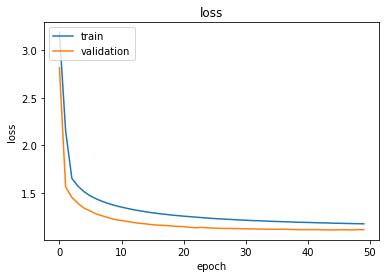

In [ ]:
# summarize history for loss
with open(model_save_file + '_history.plk', 'rb') as f:
  # if f.is_file():
    history = pickle.loads(f.read())
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

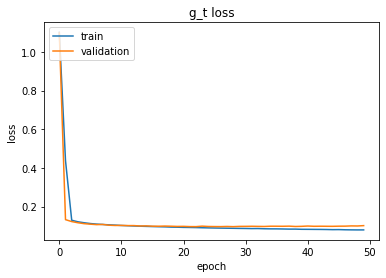

In [ ]:
# summarize history for loss
with open(model_save_file + '_history.plk', 'rb') as f:
  # if f.is_file():
    history = pickle.loads(f.read())
    plt.plot(history['output_2_loss'])
    plt.plot(history['val_output_2_loss'])
    plt.title('g_t loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

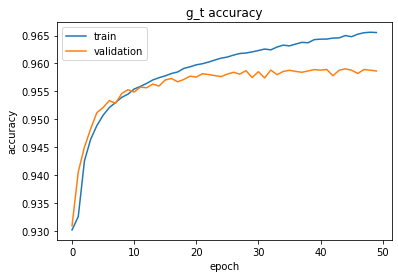

In [ ]:
# summarize history for loss
with open(model_save_file + '_history.plk', 'rb') as f:
  # if f.is_file():
    history = pickle.loads(f.read())
    plt.plot(history['output_2_accuracy'])
    plt.plot(history['val_output_2_accuracy'])
    plt.title('g_t accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

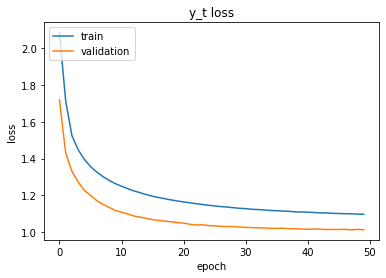

In [ ]:
# summarize history for loss
with open(model_save_file + '_history.plk', 'rb') as f:
  # if f.is_file():
    history = pickle.loads(f.read())
    plt.plot(history['output_1_loss'])
    plt.plot(history['val_output_1_loss'])
    plt.title('y_t loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

# Test

### Load Model

In [ ]:
# model = Top_Down_Buttom_Up_Model()
# model = Show_Control_and_Tell()
model.built = True
model.load_weights('/content/drive/MyDrive/Special_Topic/Show_Control_Tell/Finial/Demo4/Model_Backup/model_show_control_tell_' + str(file_num) + '.tf')

### Make word_index and index_word

In [ ]:
path = '/content/drive/MyDrive/Special_Topic/Dataset/new_dataset2/word_index_and_index_word.pkl'
with open(path, 'rb') as f:
    # data = pickle.loads(f.read())
    data = pickle.loads(f.read())
    word_index = data['word_index']
    index_word = data['index_word']

### Make Embedding Layer


In [ ]:
f = open(glove_path,encoding="utf-8")
embedded_vector_index = {}
for i in f:
  values = i.split()
  word = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embedded_vector_index[word] = coefs

embedded_matrix = np.zeros((voc_size,embedding_size))
n = 0
for word, i in word_index.items():
    embedding_vector = embedded_vector_index.get(word)
    if embedding_vector is not None: #不能map到的word為0向量
      embedded_matrix[i] = embedding_vector
      n += 1
    else:
      embedded_matrix[i] = np.random.randn(embedding_size)
emb = tf.keras.layers.Embedding(voc_size, embedding_size, mask_zero=True,name='Embedding_layer', trainable=False, weights=[embedded_matrix])

### Predict Function

In [ ]:
def predict(data):
  # data[0] -> embedding_text
  # data[1] -> img
  # data[2] -> r_t
  # data[3] -> regions_set

  # print(data)
  current_regions_set_index = 0
  for i in range(caption_max_size):
    # r_t_list = tf.get_static_value(data[2])
    # region_feature = tf.zeros(shape = (1,1024))
    # r_t_list[0][0] = region_feature
    # data[2] = tf.constant(r_t_list)

    testy, p_gt, alpha_t_buffer = model.predict(data[:3])
    # testy, p_gt = model.predict(data[:3])
    print(i, 'alpha_t_buffer', alpha_t_buffer[0][i])
    g_t_list = np.argmax(p_gt,axis=2)
    temp_p_gt = p_gt
    p_gt = tf.where(tf.greater_equal(p_gt, tf.constant([0.5])), p_gt, tf.constant([0.0]))
    g_t_tf = tf.where(tf.less(p_gt, tf.constant([0.5])), p_gt, tf.constant([1.0]))

    # g_t_list = tf.get_static_value(g_t_tf)
    if i == 29:
      # print('g_t_list',g_t_list)
      # print('p_gt', p_gt)
      break
    if i == 0:
      region_feature = tf.get_static_value(data[3][0][i])
    if g_t_list[0][i] == 1:
    # if True:
      print(i, 'shift gate')
      r_t_list = tf.get_static_value(data[2])
      if i < data[3][0].shape[0]:
        if not (tf.get_static_value(data[3][0][i][0]) == tf.get_static_value(tf.zeros([dimension]))).all():
          region_feature = tf.get_static_value(data[3][0][i])

      # region_feature = tf.zeros(shape = (1,1024))
      r_t_list[0][i+1] = region_feature
      data[2] = tf.constant(r_t_list)
    # data[2][0] = tf.zeros(shape = (30,1,1024))
    # print(i, region_feature)
    # print(i, data[2][0][:i+1+1])                        
    token_cur = np.argmax(testy,axis=2)
    tmp = emb(np.array([[token_cur[0][i]]]))
    data[0] = tf.get_static_value(data[0])
    data[0][0][i+1] = tf.get_static_value(tf.reshape(tmp, (embedding_size, )))
    data[0] = tf.constant(data[0])

  predict_text = ''
  token_cur = np.argmax(testy,axis=2) 
  for element in token_cur[0]:
    cur_word = index_word[element]
    if(cur_word == '<end>'):
      predict_text += '.'
      break
    if(cur_word != '<pad>'):
      predict_text += " " + cur_word
  if predict_text == '':
    return None 
  predict_text = predict_text[1].upper() + predict_text[2:]
  return predict_text, g_t_list, temp_p_gt

## Mode2

### Make testx and testy

In [ ]:
# path = '/content/drive/MyDrive/Special_Topic/Show_Control_Tell/Finial/Demo2/Dataset/test_dataset1.pickle'
path = '/content/drive/MyDrive/Special_Topic/Show_Control_Tell/Finial/Demo3/Dataset/test_dataset_mode_2.pickle'
with open(path, 'rb') as f:
    # data = pickle.loads(f.read())
    testx = pickle.loads(f.read())

In [ ]:
testx.keys()

dict_keys(['embedding_text', 'img', 'regions_set', 'r_t', 'y_t', 'g_t', 'image_id'])

In [ ]:
for i in testx.keys():
  if i == 'image_id':
    print(i, len(testx[i]))
    continue
  print(i, testx[i].shape)

embedding_text (3945, 30, 300)
img (3945, 1024)
regions_set (3945, 10, 1, 1024)
r_t (3945, 30, 1, 1024)
y_t (3945, 30)
g_t (3945, 30)
image_id 3945


### Start Predict

In [ ]:
loss=tf.keras.losses.BinaryCrossentropy()

In [ ]:
ts = time.time()
results = list()
error = list()

make_accuracy = tf.keras.metrics.Accuracy()
accuracy_buffer = 0
# m.update_state([[1], [2], [3], [4]], [[0], [2], [3], [4]])
# m.result().numpy()

for i in range(len(testx['image_id'])):
  print(f'({i})')
 # dict_keys(['embedding_text', 'img', 'regions_set', 'r_t', 'y_t', 'g_t', 'image_id']) 
  d, g_t_list, p_gt = predict([ tf.expand_dims(testx[j][i], axis = 0) for j in ['embedding_text', 'img', 'r_t', 'regions_set']] )
  if d == None:
    print('error')
    error.append(int(testx[3][i]))
    continue
  predict_y = d
  print('image_id', int(testx['image_id'][i]))
  print(f'predict_y: {predict_y}')
  print(f'pred g_t: {g_t_list[0]}')
  print( 'True g_t:',tf.get_static_value(testx['g_t'][i]))
  make_accuracy(g_t_list[0], tf.get_static_value(testx['g_t'][i]))
  print('g_t accuracy:', make_accuracy.result().numpy())
  accuracy_buffer += make_accuracy.result().numpy()
  print('now average g_t accuracy:', accuracy_buffer / (i+1))
  # print('loss', loss( testx['g_t'][i], p_gt).numpy())
  # print('loss', loss( testx['g_t'][i], p_gt).numpy())
  tmp = {
      'image_id': int(testx['image_id'][i]),
      'caption': predict_y,
      'g_t': g_t_list[0]
  }
  results.append(tmp)
  if i % 100 == 0:
    results_path = '/content/drive/MyDrive/Special_Topic/Show_Control_Tell/Finial/Demo4/Results/Show_Control_Tell_results_mode_2_' + str(file_num) + '.plk'
    outfile = open(results_path,'wb')
    pickle.dump(results, outfile)
    outfile.close()
    print('saved')
t = time.time() - ts
print(f'{int((t - (t % 60) - ((t - t % 60 ) / 60 % 60)) / 3600)} hr, { int((t - t % 60 ) / 60 % 60 )} min, {int(t % 60)}sec')

Streaming output truncated to the last 5000 lines.
25 alpha_t_buffer [1.0000000e+00 1.3314178e-13]
26 alpha_t_buffer [1.0000000e+00 1.3293017e-13]
27 alpha_t_buffer [1.0000000e+00 1.3272672e-13]
28 alpha_t_buffer [1.0000000e+00 1.3253092e-13]
29 alpha_t_buffer [1.0000000e+00 1.3234173e-13]
image_id 579614
predict_y: A building with a building with a building.
pred g_t: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
True g_t: [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
g_t accuracy: 0.91330713
now average g_t accuracy: 0.9124935004064327
(3815)
0 alpha_t_buffer [1.000000e+00 1.777611e-10]
1 alpha_t_buffer [1.00000e+00 2.93548e-13]
1 shift gate
2 alpha_t_buffer [1.0000000e+00 2.8295245e-13]
3 alpha_t_buffer [1.0000000e+00 1.5324826e-12]
4 alpha_t_buffer [1.0000000e+00 1.3211077e-12]
5 alpha_t_buffer [1.000000e+00 9.903957e-15]
6 alpha_t_buffer [1.0000000e+00 3.5204699e-15]
7 alpha_t_buffer [1.0000000e+00 1.1658084e-13]
8 alpha_t_buffer [1.000000e+00 7.989

In [ ]:
len(results)

3945

In [ ]:
results_path = '/content/drive/MyDrive/Special_Topic/Show_Control_Tell/Finial/Demo4/Results/Show_Control_Tell_results_mode_2_' + str(file_num) + '.plk'
outfile = open(results_path,'wb')
pickle.dump(results, outfile)
outfile.close()
del results
del testx

## Mode 1

### Make testx and testy


In [ ]:
path = '/content/drive/MyDrive/Special_Topic/Show_Control_Tell/Finial/Demo3/Dataset/test_dataset_mode_1.pickle'
with open(path, 'rb') as f:
    # data = pickle.loads(f.read())
    # testx = pickle.loads(f.read())
    testx = pickle.loads(f.read())

In [ ]:
testx.keys()

dict_keys(['embedding_text', 'img', 'regions_set', 'r_t', 'y_t', 'g_t', 'image_id'])

In [ ]:
for i in testx.keys():
  if i == 'image_id':
    print(i, len(testx[i]))
    continue
  print(i, testx[i].shape)

embedding_text (19702, 30, 300)
img (19702, 1024)
regions_set (19702, 10, 1, 1024)
r_t (19702, 30, 1, 1024)
y_t (19702, 30)
g_t (19702, 30)
image_id 19702



### Start Predict

In [ ]:
ts = time.time()
results = list()
error = list()

make_accuracy = tf.keras.metrics.Accuracy()
accuracy_buffer = 0
# m.update_state([[1], [2], [3], [4]], [[0], [2], [3], [4]])
# m.result().numpy()

for i in range(len(testx['image_id'])):
  print(f'({i})')
 # dict_keys(['embedding_text', 'img', 'regions_set', 'r_t', 'y_t', 'g_t', 'image_id']) 
  d, g_t_list, p_gt = predict([ tf.expand_dims(testx[j][i], axis = 0) for j in ['embedding_text', 'img', 'r_t', 'regions_set']] )
  if d == None:
    print('error')
    error.append(int(testx[3][i]))
    continue
  predict_y = d
  print('image_id', int(testx['image_id'][i]))
  print(f'predict_y: {predict_y}')
  print(f'pred g_t: {g_t_list[0]}')
  print( 'True g_t:',tf.get_static_value(testx['g_t'][i]))
  make_accuracy(g_t_list[0], tf.get_static_value(testx['g_t'][i]))
  print('g_t accuracy:', make_accuracy.result().numpy())
  accuracy_buffer += make_accuracy.result().numpy()
  print('now average g_t accuracy:', accuracy_buffer / (i+1))
  # print('loss', loss( testx['g_t'][i], p_gt).numpy())
  # print('loss', loss( testx['g_t'][i], p_gt).numpy())
  tmp = {
      'image_id': int(testx['image_id'][i]),
      'caption': predict_y,
      'g_t': g_t_list[0]
  }
  results.append(tmp)
  if i == 4:
    break
t = time.time() - ts
print(f'{int((t - (t % 60) - ((t - t % 60 ) / 60 % 60)) / 3600)} hr, { int((t - t % 60 ) / 60 % 60 )} min, {int(t % 60)}sec')

(0)
0 alpha_t_buffer [0.9981704  0.00182956]
1 alpha_t_buffer [0.20282575 0.7971743 ]
1 shift gate
2 alpha_t_buffer [0.2826789 0.7173211]
3 alpha_t_buffer [0.16274908 0.83725095]
4 alpha_t_buffer [0.0551052 0.9448948]
5 alpha_t_buffer [0.14347556 0.8565244 ]
6 alpha_t_buffer [0.26699552 0.73300445]
7 alpha_t_buffer [0.09594227 0.90405774]
8 alpha_t_buffer [0.129114   0.87088597]
9 alpha_t_buffer [0.18343078 0.81656927]
10 alpha_t_buffer [0.1262166 0.8737834]
11 alpha_t_buffer [0.05923037 0.9407697 ]
12 alpha_t_buffer [0.21157148 0.7884285 ]
13 alpha_t_buffer [0.11485622 0.8851437 ]
14 alpha_t_buffer [0.09485358 0.90514636]
15 alpha_t_buffer [0.10180862 0.8981914 ]
16 alpha_t_buffer [0.09997287 0.9000272 ]
17 alpha_t_buffer [0.09831367 0.9016863 ]
18 alpha_t_buffer [0.09728519 0.9027148 ]
19 alpha_t_buffer [0.09762865 0.90237135]
20 alpha_t_buffer [0.09763639 0.90236366]
21 alpha_t_buffer [0.09765366 0.9023464 ]
22 alpha_t_buffer [0.09760917 0.90239084]
23 alpha_t_buffer [0.09762865 0.9

In [ ]:
len(results)

In [ ]:
results_path = '/content/drive/MyDrive/Special_Topic/Show_Control_Tell/Finial/Demo4/Results/Show_Control_Tell_results_mode_1_' + str(file_num) + '.plk'
outfile = open(results_path,'wb')
pickle.dump(results, outfile)
outfile.close()
print('saved')

# Val

In [ ]:
path = '/content/drive/MyDrive/Special_Topic/Show_Control_Tell/Finial/Demo4/Dataset/val_dataset.pickle'
with open(path, 'rb') as f:
    # data = pickle.loads(f.read())
    # testx = pickle.loads(f.read())
    testx = pickle.loads(f.read())

In [ ]:
testx.keys()

dict_keys(['embedding_text', 'img', 'regions_set', 'r_t', 'y_t', 'g_t', 'image_id'])

In [ ]:
for i in testx.keys():
  if i == 'image_id':
    print(i, len(testx[i]))
    continue
  print(i, testx[i].shape)

embedding_text (12492, 30, 300)
img (12492, 1024)
regions_set (12492, 10, 1, 1024)
r_t (12492, 30, 1, 1024)
y_t (12492, 30)
g_t (12492, 30)
image_id 12492


In [ ]:
id = 6

In [ ]:
testx['image_id'][id]

<tf.Tensor: shape=(), dtype=string, numpy=b'458632'>

In [ ]:
testx['regions_set'][id][:5]

<tf.Tensor: shape=(5, 1, 1024), dtype=float32, numpy=
array([[[0.05094796, 0.33021858, 0.03713493, ..., 1.8465428 ,
         0.        , 0.01065902]],

       [[0.        , 0.01615019, 0.15801531, ..., 0.61814445,
         0.        , 0.44552833]],

       [[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]],

       [[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]],

       [[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]]], dtype=float32)>

In [ ]:
testx['r_t'][id]

<tf.Tensor: shape=(30, 1, 1024), dtype=float32, numpy=
array([[[0.05094796, 0.33021858, 0.03713493, ..., 1.8465428 ,
         0.        , 0.01065902]],

       [[0.05094796, 0.33021858, 0.03713493, ..., 1.8465428 ,
         0.        , 0.01065902]],

       [[0.        , 0.01615019, 0.15801531, ..., 0.61814445,
         0.        , 0.44552833]],

       ...,

       [[0.        , 0.01615019, 0.15801531, ..., 0.61814445,
         0.        , 0.44552833]],

       [[0.        , 0.01615019, 0.15801531, ..., 0.61814445,
         0.        , 0.44552833]],

       [[0.        , 0.01615019, 0.15801531, ..., 0.61814445,
         0.        , 0.44552833]]], dtype=float32)>

In [ ]:
ts = time.time()
results = list()
error = list()

make_accuracy = tf.keras.metrics.Accuracy()
accuracy_buffer = 0
# m.update_state([[1], [2], [3], [4]], [[0], [2], [3], [4]])
# m.result().numpy()

for i in range(len(testx['image_id'])):
  print(f'({i})')
 # dict_keys(['embedding_text', 'img', 'regions_set', 'r_t', 'y_t', 'g_t', 'image_id']) 
  d, g_t_list, p_gt = predict([ tf.expand_dims(testx[j][i], axis = 0) for j in ['embedding_text', 'img', 'r_t', 'regions_set']] )
  if d == None:
    print('error')
    error.append(int(testx[3][i]))
    continue
  predict_y = d
  print('image_id', int(testx['image_id'][i]))
  print(f'predict_y: {predict_y}')
  print(f'pred g_t: {g_t_list[0]}')
  print( 'True g_t:',tf.get_static_value(testx['g_t'][i]))
  make_accuracy(g_t_list[0], tf.get_static_value(testx['g_t'][i]))
  print('g_t accuracy:', make_accuracy.result().numpy())
  accuracy_buffer += make_accuracy.result().numpy()
  print('now average g_t accuracy:', accuracy_buffer / (i+1))
  # print('loss', loss( testx['g_t'][i], p_gt).numpy())
  # print('loss', loss( testx['g_t'][i], p_gt).numpy())
  tmp = {
      'image_id': int(testx['image_id'][i]),
      'caption': predict_y,
      'g_t': g_t_list[0]
  }
  results.append(tmp)
  # if i == 20:
  #   break
t = time.time() - ts
print(f'{int((t - (t % 60) - ((t - t % 60 ) / 60 % 60)) / 3600)} hr, { int((t - t % 60 ) / 60 % 60 )} min, {int(t % 60)}sec')

Streaming output truncated to the last 5000 lines.
3 alpha_t_buffer [1.0000000e+00 3.6049443e-12]
4 alpha_t_buffer [1.000000e+00 6.934687e-13]
5 alpha_t_buffer [1.000000e+00 9.106745e-14]
6 alpha_t_buffer [1.0000000e+00 1.1996785e-13]
7 alpha_t_buffer [1.000000e+00 1.760095e-13]
8 alpha_t_buffer [1.0000000e+00 1.0694469e-13]
9 alpha_t_buffer [1.0000000e+00 4.0782866e-13]
10 alpha_t_buffer [1.0000000e+00 5.2956103e-14]
11 alpha_t_buffer [1.000000e+00 7.247497e-14]
12 alpha_t_buffer [1.0000000e+00 8.7634523e-14]
13 alpha_t_buffer [1.000000e+00 8.559664e-14]
14 alpha_t_buffer [1.000000e+00 8.537163e-14]
15 alpha_t_buffer [1.000000e+00 8.631505e-14]
16 alpha_t_buffer [1.000000e+00 8.611426e-14]
17 alpha_t_buffer [1.000000e+00 8.578836e-14]
18 alpha_t_buffer [1.000000e+00 8.565298e-14]
19 alpha_t_buffer [1.0000000e+00 8.5518635e-14]
20 alpha_t_buffer [1.0000000e+00 8.5386776e-14]
21 alpha_t_buffer [1.000000e+00 8.526325e-14]
22 alpha_t_buffer [1.0000000e+00 8.5151436e-14]
23 alpha_t_buffer 

In [ ]:
len(results)

In [ ]:
results_path = '/content/drive/MyDrive/Special_Topic/Show_Control_Tell/Finial/Demo4/Results/Show_Control_Tell_results_val_' + str(file_num) + '.plk'
outfile = open(results_path,'wb')
pickle.dump(results, outfile)
outfile.close()
print('saved')